First, import modules

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot
import random
import math
import time
from IPython.display import clear_output

Define the state. 0 is cooperate, 1 is defect. The state is therefore (in binary) 00 for CC, 01 for CD, 10 for DC and 11 for DD

In [2]:
def advance(action1, action2):
  newstate = 2*action1 + action2
  return newstate



Secondly, set up the rewards matrix. This is set up so reward[state][playernumber] returns the reward for that player

In [3]:
#rewards = [[-1, -1],[-3, 0],[0, -3],[-2, -2],[0,0]]
#[[-0.1, -0.1],[-0.3, 0],[0, -0.3],[-0.2, -0.2],[0,0]]
rewards = [[3, 3],[0, 5],[5, 0],[1, 1],[0,0]]


Next we define parameters for the epsilon greedy function

In [4]:
#Learning rate
alpha1 = 0.01
alpha2 = 0.01

#Discount factor. 0 means future rewards not considered
gamma1 = 0.95
gamma2 = 0.95

#Exploration rate. Higher means more random exploration
epsilon1 = 0.01
epsilon2 = 0.01

Next, we create the epsilon greedy function. This takes the Q values and state, and returns an action. 

If a random value between 0 and 1 is bigger then epsilon, then choose the biggest Q, else choose a random action

In [5]:
def epsilongreedy(Q, state, e):
  randval = random.random()
  Qvals_for_state = Q[state,:]

  if randval > e and not Qvals_for_state[0] == Qvals_for_state[1]:
    
    action = np.argmax(Qvals_for_state)

  else:
    action = random.randrange(Qvals_for_state.size)

  return action


In [6]:
def stochastic_choose(Q, state, t):
  Qvals_for_state = Q[state,:].copy()
  randval = random.random()

  boundary = np.exp(Qvals_for_state[0]/t)/np.exp((Qvals_for_state[0]/t)+np.exp(Qvals_for_state[1]/t))

  if randval < boundary:
    return 0

  else:
    return 1

In [7]:
def transformstate(state):
  if state == 1:
    transformedstate = 2
  elif state == 2:
    transformedstate = 1
  else: transformedstate = state
  return transformedstate

def transformQ(Q):
  transformedQ = Q.copy()
  transformedQ[2] = Q[1].copy()
  transformedQ[1] = Q[2].copy()
  return transformedQ

In [8]:
def TFT_check(Q):
  if Q[0][0] > Q[0][1] and Q[1][0] < Q[1][1] and Q[2][0] > Q[2][1] and Q[3][0] < Q[3][1] and Q[4][0] > Q[4][1]:
    return 1
  else:
    return 0

def Co_op_check(Q):
  if Q[0][0] > Q[0][1] and Q[2][0] > Q[2][1] and Q[4][0] > Q[4][1]:
    return 1
  else:
    return 0

def Grim_check(Q):
  if Q[0][0] > Q[0][1] and Q[1][0] < Q[1][1] and Q[2][0] < Q[2][1] and Q[3][0] < Q[3][1] and Q[4][0] > Q[4][1]:
    return 1
  else:
    return 0



In [9]:
def strategy_classify(Q):
    out = ""
    for n in range(5):
        if Q[n][0] > Q[n][1] :
            out += "C"
        else:
            out += "D"
    return out

In [10]:
def two_strat_classify(Q2,Q1):
    out = 0

    if np.array_equal(Q2, np.zeros([5,2])):
        return 1024
    
    else:
        for i in range(5):
            if Q1[i][0] < Q1[i][1] :
                out += 2**i

        for i in range(5):
            if Q2[i][0] < Q2[i][1] :
                out += 2**(i+5)

        return out


In [12]:
#Grim Trigger:
grim_trigger = np.array([[29.99999, 0], [0, 29.9999], [0, 29.9999], [0, 29.9999], [29.9999, 0]])

#TFT
TFT1 = np.array([[100.0, 60.0], [60.0, 100.0], [100.0, 60.0], [60.0, 100.0], [100.0, 60.0]])
TFT2 = np.array([[100.09, 60.0], [100.0, 60.0], [60.0, 100.0], [60.0, 100.0], [100.0, 60.0]])

#Always Coop
always_CoOp = np.array([[100.0, 60.0], [100.0, 60.0], [100.0, 60.0], [100.0, 60.0], [100.0, 60.0]])

#Always Defect
always_defect = np.array([[19.4, 20.4], [19.4, 20.4], [19.4, 20.4], [19.4, 20.4], [19.4, 20.4]])

#Zero
Q_zero = np.zeros([5,2])

#Pavlov
Pavlov = np.array([[100.0, 60.0], [60.0, 100.0], [60.0, 100.0], [100.0, 60.0], [100.0, 60.0]])

D = np.array([0, 1])
C = np.array([1,0])


next we do Q learning

In [13]:
def Qlearning(rewards, num_episodes, num_steps, alpha1, alpha2, gamma1, gamma2, epsilon1, epsilon2, debug = False, Q_Player_A_preset = TFT1, Q_Player_B_preset = TFT2):
  Q_Player_A = Q_Player_A_preset.copy()
  Q_Player_B = Q_Player_B_preset.copy()
  episode_rewards_A = []
  episode_rewards_B = []
  TFT_A = []
  TFT_B = []
  CoOp_A = []
  CoOp_B = []
  Grim_A = []
  Grim_B = []
  Q_A_array = np.zeros((num_episodes, 5, 2))
  Q_B_array = np.zeros((num_episodes, 5, 2))
  Strat_transition = np.zeros([1025,1024])


  for episode in range(num_episodes):
    episode_reward_A = 0
    episode_reward_B = 0
    state = 4 #set default initial state
    
    for step in range(num_steps):
      strat_transition_row = two_strat_classify(Q_Player_A,Q_Player_B)
      actionA = epsilongreedy(Q_Player_A, state, epsilon1)
      actionB = epsilongreedy(Q_Player_B, state, epsilon2)
      next_state = advance(actionA, actionB)

      reward_A = rewards[next_state][0]
      episode_reward_A += reward_A

      reward_B = rewards[next_state][1]
      episode_reward_B += reward_B
      
      #update Q for A
      best_next_actionA = np.argmax(Q_Player_A[next_state,:])

      td_targetA = reward_A + gamma1 * Q_Player_A[next_state, best_next_actionA]

      td_deltaA = td_targetA - Q_Player_A[state][actionA]

    
      # Update Q for B

      best_next_actionB = np.argmax(Q_Player_B[next_state,:])

      td_targetB = reward_B + gamma2 * Q_Player_B[next_state, best_next_actionB]


      td_deltaB = td_targetB - Q_Player_B[state][actionB]


        
      Q_Player_A[state][actionA] = Q_Player_A[state][actionA] + alpha1 * td_deltaA
      Q_Player_B[state][actionB] += alpha2 * td_deltaB
      
      
      strat_transition_column = two_strat_classify(Q_Player_A,Q_Player_B)

      Strat_transition[strat_transition_row][strat_transition_column] += 1
      state = next_state
    episode_rewards_A.append(episode_reward_A)
    episode_rewards_B.append(episode_reward_B)
    TFT_A.append(TFT_check(Q_Player_A))
    TFT_B.append(TFT_check(transformQ(Q_Player_B)))
    CoOp_A.append(Co_op_check(Q_Player_A))
    CoOp_B.append(Co_op_check(transformQ(Q_Player_B)))
    Grim_A.append(Grim_check(Q_Player_A))
    Grim_B.append(Grim_check(Q_Player_B))
    Q_A_array[episode,:,:]=Q_Player_A
    Q_B_array[episode,:,:]=Q_Player_B

    
  return Q_Player_A, Q_Player_B, episode_rewards_A, episode_rewards_B, TFT_A, TFT_B, CoOp_A, CoOp_B, Grim_A, Grim_B, Q_A_array, Q_B_array, Strat_transition

In [14]:
Q_A, Q_B, episode_rewards_A, episode_rewards_B, TFT_A, TFT_B, CoOp_A, CoOp_B, Grim_A, Grim_B, Q_A_Array, Q_B_Array, strat_transition = Qlearning(rewards, 250000, 50, alpha1, alpha2, gamma1, gamma2, epsilon1,  epsilon2, False, Q_zero,Q_zero)     #Set the bool to false to run Q learning, true to see what it does at every step. Input Q as the last input to keep learned variables and remove it to learn from scratch
#Q_A, Q_B, episode_rewards_A, episode_rewards_B, TFT_A, TFT_B, CoOp_A, CoOp_B, Grim_A, Grim_B, Q_A_Array, Q_B_Array = Qlearning(rewards, 100000, 50, alpha1, alpha2, gamma1, gamma2, epsilon1,  epsilon2, False, Q_A,Q_A)
#Q_A, Q_B, episode_rewards_A, episode_rewards_B = Qlearning(rewards, 10000, 10, alpha1, alpha2, gamma1, gamma2, epsilon1,  epsilon2, False, np.zeros((5, 2)), np.zeros((5, 2)))

print(Q_A)
print(Q_B)

print(strategy_classify(Q_A) + strategy_classify(Q_B))



IndexError: index 1024 is out of bounds for axis 0 with size 1024

In [ ]:
matplotlib.pyplot.plot(episode_rewards_A, label = "Agent 1")

matplotlib.pyplot.plot(episode_rewards_B, label = "Agent 2")
matplotlib.pyplot.title("Total reward in each epsiode for 2 agents starting at cooperation")
matplotlib.pyplot.xlabel("Episode Number")
matplotlib.pyplot.ylabel("Total reward per episode")
matplotlib.pyplot.legend()

In [18]:
transitionmatrix = np.zeros([1025,1024])

In [19]:
for i in range(10): 
    Q_A, Q_B, episode_rewards_A, episode_rewards_B, TFT_A, TFT_B, CoOp_A, CoOp_B, Grim_A, Grim_B, Q_A_Array, Q_B_Array, strat_transition = Qlearning(rewards, 500000, 50, alpha1, alpha2, gamma1, gamma2, epsilon1,  epsilon2, False, Q_zero,Q_zero)
    transitionmatrix += strat_transition

KeyboardInterrupt: 

In [130]:
np.savetxt("QTransition_one_episode.csv", strat_transition, delimiter=",")

Text(0, 0.5, 'Will Q choose TFT ignoring randomness?')

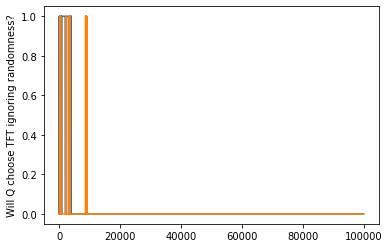

In [56]:
matplotlib.pyplot.plot(TFT_A)
matplotlib.pyplot.plot(TFT_B)
matplotlib.pyplot.ylabel("Will Q choose TFT ignoring randomness?")

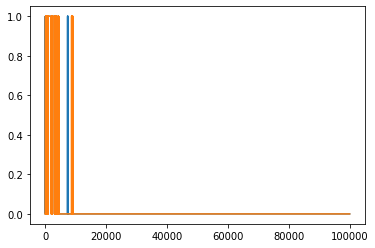

In [57]:
matplotlib.pyplot.plot(CoOp_A)
matplotlib.pyplot.plot(CoOp_B)

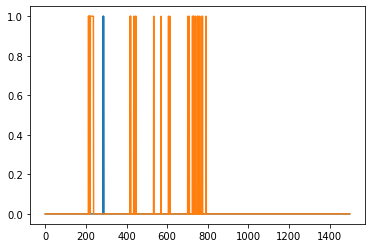

In [16]:
matplotlib.pyplot.plot(Grim_A)
matplotlib.pyplot.plot(Grim_B)

In [72]:
print(grim_trigger)

[[29.99999  0.     ]
 [ 0.      29.9999 ]
 [ 0.      29.9999 ]
 [ 0.      29.9999 ]
 [29.9999   0.     ]]


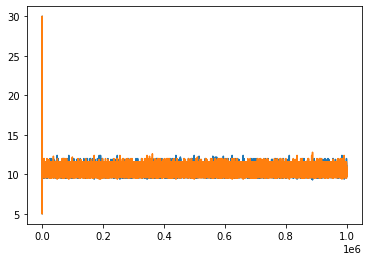

In [18]:
rewards_averaged_A = []
counter = 0
for count in range(len(episode_rewards_A)):
  counter += episode_rewards_A[count]
  if count % 10 == 9:
    rewards_averaged_A.append(counter/10)
    counter = 0

rewards_averaged_B = []
counter = 0
for count in range(len(episode_rewards_B)):
  counter += episode_rewards_B[count]
  if count % 10 == 9:
    rewards_averaged_B.append(counter/10)
    counter = 0
matplotlib.pyplot.plot(rewards_averaged_A)
matplotlib.pyplot.plot(rewards_averaged_B)

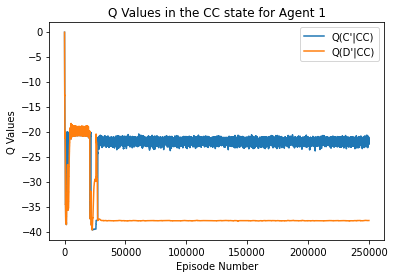

In [110]:
#CC
fig = matplotlib.pyplot.figure()
matplotlib.pyplot.plot(Q_A_Array[:,0,0], label = "Q(C'|CC)")
matplotlib.pyplot.plot(Q_A_Array[:,0,1], label = "Q(D'|CC)")
matplotlib.pyplot.title("Q Values in the CC state for Agent 1")
matplotlib.pyplot.xlabel("Episode Number")
matplotlib.pyplot.ylabel("Q Values")
matplotlib.pyplot.legend()
#fig.savefig("GrimCCSS.eps")

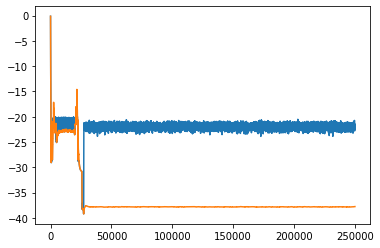

In [111]:
#CC agent2

matplotlib.pyplot.plot(Q_B_Array[:,0,0])
matplotlib.pyplot.plot(Q_B_Array[:,0,1])

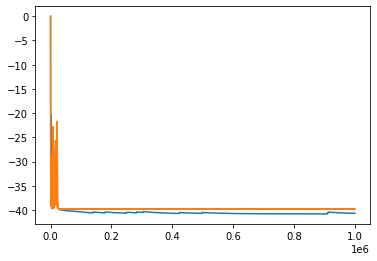

In [80]:
#CD

matplotlib.pyplot.plot(Q_A_Array[:,1,0])
matplotlib.pyplot.plot(Q_A_Array[:,1,1])

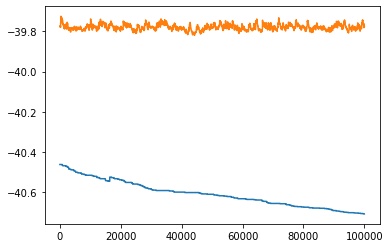

In [68]:
#DC

matplotlib.pyplot.plot(Q_A_Array[:,2,0])
matplotlib.pyplot.plot(Q_A_Array[:,2,1])

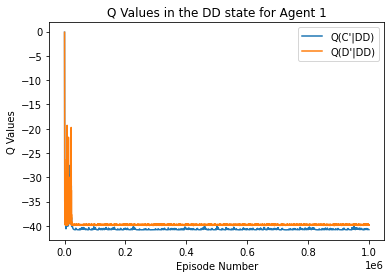

In [81]:
#DD
fig = matplotlib.pyplot.figure()
matplotlib.pyplot.plot(Q_A_Array[:,3,0], label = "Q(C'|DD)")
matplotlib.pyplot.plot(Q_A_Array[:,3,1], label = "Q(D'|DD)")
matplotlib.pyplot.title("Q Values in the DD state for Agent 1")
matplotlib.pyplot.xlabel("Episode Number")
matplotlib.pyplot.ylabel("Q Values")
matplotlib.pyplot.legend()
#fig.savefig("GrimDDSS.eps")

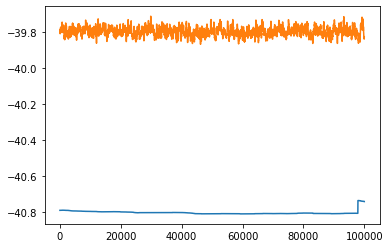

In [70]:
#Initial

matplotlib.pyplot.plot(Q_A_Array[:,4,0])
matplotlib.pyplot.plot(Q_A_Array[:,4,1])

In [40]:
import csv
header = ["Init-C","Init-D","CC-C","CC-D", "CD-C", "CD-D", "DC-C", "DC-D", "DD-C", "DD-D","epsilonlst"]
# open the file in the write mode
with open('MeasuredQsPav.csv', 'w',encoding='UTF8', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(header)
    for eps2 in range(1001):
        Q_A, Q_B, episode_rewards_A, episode_rewards_B, TFT_A, TFT_B, CoOp_A, CoOp_B, Grim_A, Grim_B, Q_A_Array, Q_B_Array = Qlearning(rewards, 10000, 50, 0.01, 0, 0.95, 0.9, 0.2,  eps2/1000, False, Q_zero, Pavlov)
        
        CC0=Q_A[0,0]
        CC1=Q_A[0,1]
        CD0=Q_A[1,0]
        CD1=(Q_A[1,1])
        DC0=(Q_A[2,0])
        DC1=(Q_A[2,1])
        DD0=(Q_A[3,0])
        DD1=(Q_A[3,1])
        Init0=(Q_A[4,0])
        Init1=(Q_A[4,1])
        writer.writerow([  Init0,Init1,CC0,CC1, CD0, CD1, DC0, DC1, DD0, DD1,eps2/1000])

    


In [ ]:
import csv
header = ["1Init-C","1Init-D","1CC-C","1CC-D", "1CD-C", "1CD-D", "1DC-C", "1DC-D", "1DD-C", "1DD-D","2Init-C","2Init-D","2CC-C","2CC-D", "2CD-C", "2CD-D", "2DC-C", "2DC-D", "2DD-C", "2DD-D","ep_num"]
Q_A = Q_zero
Q_B = Q_zero
# open the file in the write mode
with open('Coopstability.csv', 'w',encoding='UTF8', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(header)
    for eps2 in range(1001):
        Q_A, Q_B, episode_rewards_A, episode_rewards_B, TFT_A, TFT_B, CoOp_A, CoOp_B, Grim_A, Grim_B, Q_A_Array = Qlearning(rewards, 10000, 50, 0.01, 0, 0.9, 0.9, 0.2,  eps2/1000, False, Q_zero, grim_trigger)
        
        CC0=d[0,0]
        CC1=d[0,1]
        CD0=d[1,0]
        CD1=(d[1,1])
        DC0=(d[2,0])
        DC1=(d[2,1])
        DD0=(d[3,0])
        DD1=(d[3,1])
        Init0=(Q_A[4,0])
        Init1=(Q_A[4,1])
        writer.writerow([Init0,Init1,CC0,CC1, CD0, CD1, DC0, DC1, DD0, DD1,eps2/1000])
